In [59]:
import numpy as np
import pandas as pd 
import time, math
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.metrics import roc_auc_score, classification_report, log_loss
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn import model_selection, preprocessing, ensemble
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
import patsy
from scipy import sparse
from sklearn import neighbors, metrics, svm
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm
# from bokeh.io import output_notebook, show
# from bokeh.charts import Histogram, output_file
# from bokeh.plotting import figure
from mpl_toolkits.basemap import Basemap
# output_notebook()
%matplotlib inline 

In [798]:
# %matplotlib notebook

In [436]:
sns.set(palette='dark')

In [60]:
# clean up some listings.  Quick look at the summary and some details.

def index_lookup(index):
    print df.ix[index]
    print 'Full description: '
    print df.ix[index]['description'] # close look at the description:
    print 'Links to photos: '
    for c in df.ix[index]['photos']:      # check the images:
        print c

starting a list of indexes that have bad/questionable data:
53144, 87511, 117339, 32611, 113552, 85617, 113599, 102756, 22693, 109164, 51007, 115551, 83581, 95901, 88385, 55437, 57803, 106350, 2028, 37426, 39134, 46941, 49884, 63688, 66197, 69423, 70841, 76934, 85521



# <center> Predict How Popular an Apartment Rental Listing Will Be</center>

How do you define 'popular'.  If a place has a low price more people are probably going to view it.  There are some things to think about here.

In [3]:
df = pd.read_json('/Users/smoot/Downloads/train.json')
df_t = pd.read_json('/Users/smoot/Downloads/test.json')
print 'training data:', df.shape
print 'test data:', df_t.shape
df.head(3)

training data: (49352, 15)
test data: (74659, 14)


,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street


### <center>Target--interest_level </center>

Three classes--low, medium and high.  Not a lot of highs but lots of lows.  There is probably a lot of garbage in the lows.  Maybe we can eliminate some of the garbage listings.

        interest_level
low              34284
medium           11229
high              3839


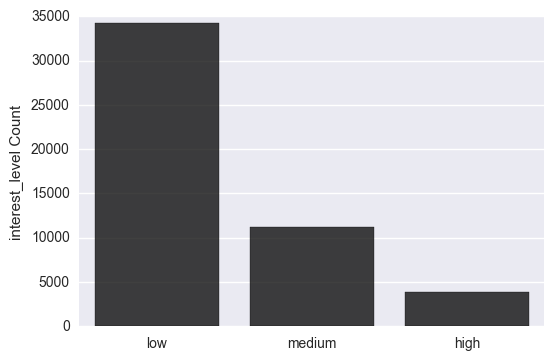

In [4]:
tt = pd.DataFrame(df['interest_level'].value_counts())
sns.barplot(tt.index, tt['interest_level'], color='black', alpha=0.75)
plt.ylabel('interest_level Count')
print tt
plt.show()

By looking at the standard deviation of bathrooms, bedrooms and price, we can see that bathrooms and bedrooms are quite consistent throughout each interest level.  There is a large descrepancy, however, for price. It is beginning to look like price has a significant impact on our target variable--interest_level or there could just be a lot of bad data.

In [5]:
# grouped by interest_level and only looking at bathrooms, bedrooms and price because long, lat and listing_id aren't
# not relevant here.

gp_mean = df.groupby(df['interest_level'])['bathrooms', 'bedrooms', 'price'].mean()
print gp_mean
gp = pd.DataFrame(df.groupby(df['interest_level'])['bathrooms', 'bedrooms', 'price'].mean().std(), columns=['std_dev'])
print '------------------------------------------------'
print gp

                bathrooms  bedrooms        price
interest_level                                  
high             1.116176  1.546496  2700.293045
low              1.238741  1.514759  4176.599142
medium           1.163906  1.622050  3158.767388
------------------------------------------------
              std_dev
bathrooms    0.061780
bedrooms     0.055116
price      755.607912


# <center> EDA By Feature </center>

To begin we will plot all of our data in a pairplot to get a lay of the land so-to-speak.  After a brief observation of the data we can see that there are a few outliers.  For example, it seems there is one listing that is incredibly expensive, one listing with a ton of bathrooms and a few wacky long/lat coordinates.  We will take a closer look at these as we continue to explore the data.

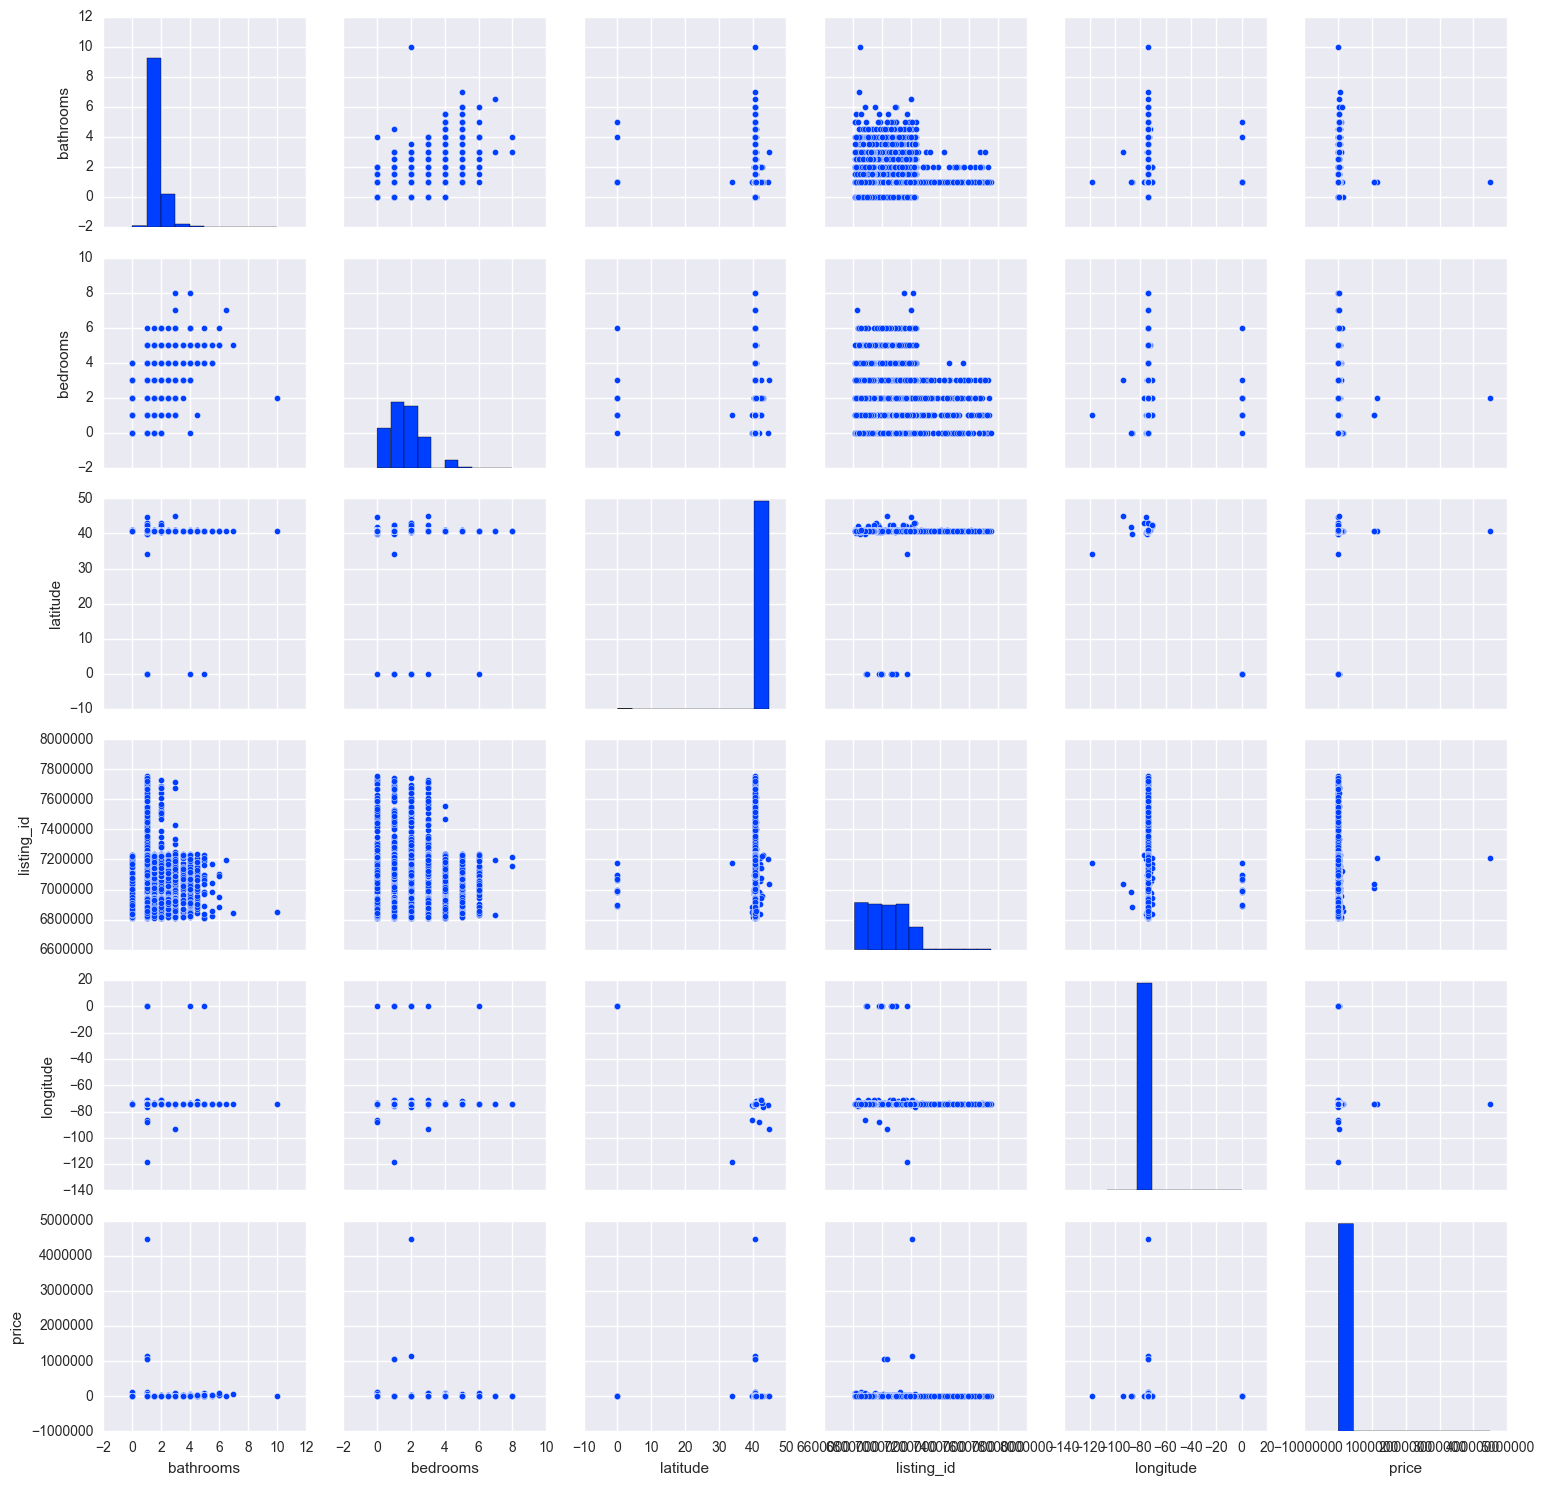

In [378]:
sns.pairplot(df)

### <center>Bathrooms</center>

Initial thoughts:
- There are 313 listings that do not have a bathroom.  
- There are a few outliers to consider (i.e. 10 bathrooms)
- The distribution of # of bathrooms is not normal.

      bathrooms
1.0       39422
2.0        7660
3.0         745
1.5         645
0.0         313
2.5         277
4.0         159
3.5          70
4.5          29
5.0          20
5.5           5
6.0           4
6.5           1
10.0          1
7.0           1


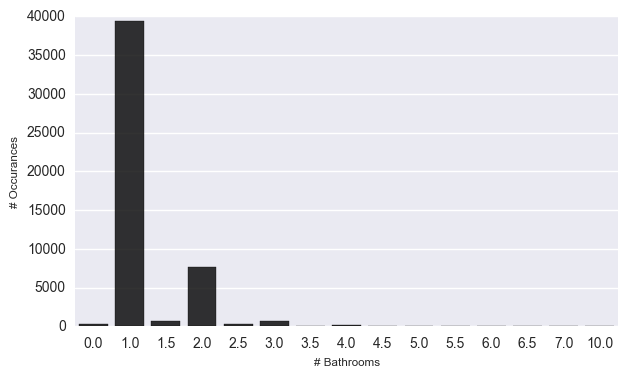

In [6]:
baths_df = pd.DataFrame(df['bathrooms'].value_counts())
baths = df['bathrooms'].value_counts()
plt.figure(figsize=(7,4))
plt.ylabel('# Occurances', fontsize='small')
plt.xlabel('# Bathrooms', fontsize='small')
sns.barplot(baths.index, baths.values, alpha=0.8, color='black')
print baths_df
plt.show()

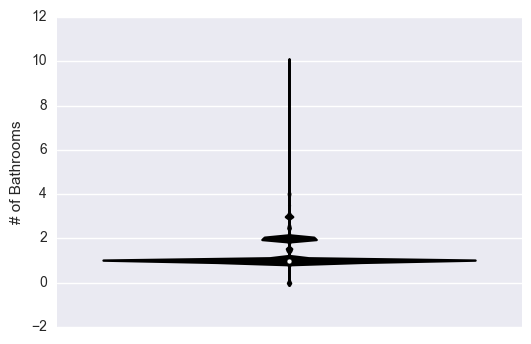

In [7]:
sns.violinplot(df['bathrooms'], orient='v', color='black')
plt.ylabel('# of Bathrooms')

I'm curious what the descriptions of the listings with 0 bathrooms might have to say.  If there is no bathroom it would make sense if that listing didn't garner much interest.  

### <center> Bedrooms </center>

Initial thoughts:
- 0 bedrooms is likely a studio
- not a normal distribution but close

In [8]:
bedrms = pd.groupby(df['bedrooms'].value_counts(), df['interest_level'].value_counts())

   bedrooms
1     15752
2     14623
0      9475
3      7276
4      1929
5       247
6        46
8         2
7         2


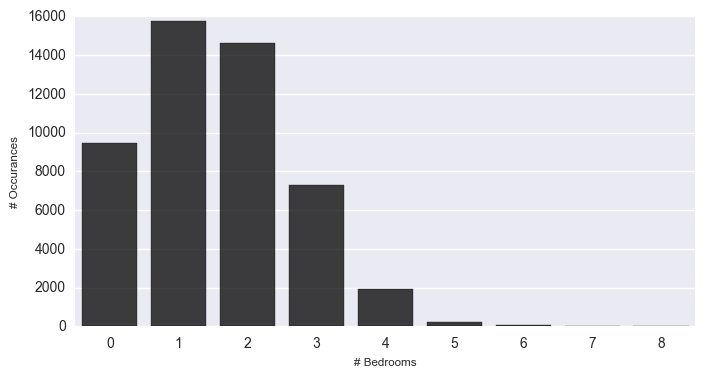

In [9]:
bedrms = pd.DataFrame(df['bedrooms'].value_counts())
bedrooms = df['bedrooms'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(bedrooms.index, bedrooms.values, alpha=0.75, color='black')
plt.ylabel('# Occurances', fontsize='small')
plt.xlabel('# Bedrooms', fontsize='small')
print bedrms
plt.show() 

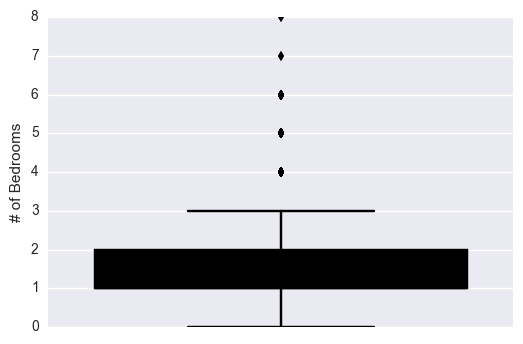

In [10]:
sns.boxplot(df['bedrooms'], orient='v', color='black')
plt.ylabel('# of Bedrooms')

In [11]:
# total listings without a bathroom or a bedroom.
mask = (df['bathrooms'] == 0.0) & (df['bedrooms'] == 0)
no_baths = df[mask]
no_baths.shape

(157, 15)

### <center>Price</center>

In [12]:
gp_price = pd.DataFrame(df.groupby(['interest_level'])['price'].mean())
gp_price

,price
interest_level,
high,2700.293045
low,4176.599142
medium,3158.767388


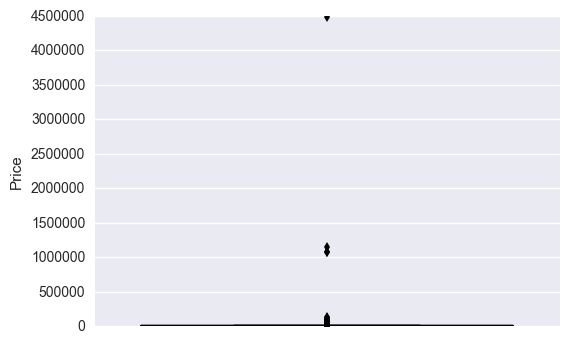

In [13]:
sns.boxplot(df['price'], orient='v', color='black')
plt.ylim(0)
plt.ylabel('Price')

From the boxplot above we can see there are some prices that need to be examined.  I doubt there is going to be much interest (or a legitimate rental listing) for an apartment that is renting at 4.49 million dollars per month.  I also doubt there is an apartment for rent in New York City for just $43 a month.  We can inspect these and other questionable listings to determine if they are mistakes and something we can fix or if they are just garbage.    

In [14]:
price_list = df['price'].sort_values()
print 'Least Expensive Listings:'
print price_list[:10]
print '-------------------------'
print 'Most Expensive Listings:'
print price_list[49342:]
# may want to investigate more than the top/bottom 10

Least Expensive Listings:
53144      43
87511      45
117339    401
113552    695
85617     695
113599    695
102756    695
22693     700
109164    800
61138     868
Name: price, dtype: int64
-------------------------
Most Expensive Listings:
96905       80000
116586      85000
54148       90000
91709      100000
4620       111111
123877     135000
55437     1070000
57803     1070000
12168     1150000
32611     4490000
Name: price, dtype: int64


In [61]:
index_lookup(123877)

bathrooms                                                          0
bedrooms                                                           0
building_id                                                     8453
created                                          2016-04-12 02:11:10
description        Originally built in 1862, this extraordinary l...
display_address                                                 9239
features           Elevator Pre-War Terrace Dogs_Allowed Cats_All...
interest_level                                                   low
latitude                                                     40.7161
listing_id                                                   6857401
longitude                                                    -74.008
manager_id                                                      3748
photos             [https://photos.renthop.com/2/6857401_a4a4c2f2...
price                                                         135000
street_address                    

(49335, 15)

### <center>Building ID</center>

Initial thoughts:
- could try label encoding here to use these as a feature
- 7,588 missing building ids

I'm not really seeing much from building_id.  There are a handful of buildings that show up frequently but they seem to have a distribution that matches the overall interest_level distribution.  Maybe a feature to come back to at a later time.

In [16]:
dd = df['building_id'].value_counts()
print 'Total unique building ids:', len(dd)

Total unique building ids: 7585


In [17]:
gp_b_id = df.groupby([df['interest_level'], df['building_id']])['listing_id'].count()
gp_b_id.ix['low'].sort_values(ascending=False)[:10]

building_id
0                                   7588
96274288c84ddd7d5c5d8e425ee75027     179
11e1dec9d14b1a9e528386a2504b3afc     145
c94301249b8c09429d329864d58e5b82     140
80a120d6bc3aba97f40fee8c2204524b     125
f68bf347f99df026f4faad43cc604048     116
9c18bf871b97492b96d8ddb800591f1b     112
bb8658a3e432fb62a440615333376345     111
8e3b8c607c3edcf3de131c24f0390179     110
cb14c4f807f23ecee1f7469b5159d2de     109
Name: listing_id, dtype: int64

### <center>Created</center>

In [125]:
df['created'].value_counts()[:20]

2016-06-16 04:08:35    3
2016-05-18 01:36:49    3
2016-05-14 05:23:52    3
2016-06-21 04:44:43    3
2016-06-11 01:20:36    3
2016-05-14 01:11:03    3
2016-06-25 01:30:16    3
2016-05-17 14:29:08    3
2016-04-08 01:14:27    3
2016-06-12 13:20:45    3
2016-05-27 03:59:28    3
2016-06-05 01:32:36    3
2016-06-12 12:30:28    3
2016-05-02 03:41:36    3
2016-04-15 02:24:25    3
2016-04-27 03:21:54    2
2016-04-06 04:39:39    2
2016-06-01 05:23:15    2
2016-06-28 05:24:36    2
2016-06-08 06:28:23    2
Name: created, dtype: int64

### <center>Description</center>

Initial thoughts:
- there is a lot of data here and it looks like it could be cleaned up a bit
- find if the listing is a shared room by searching for words like 'shared', 'roomate', etc.
- maybe something similar for other things like newly remodeled or something
- look into topic modeling by interest_level

The feature engineering that can be done on descriptions will be labor intensive so I'm going to wait before really digging into this.  Just to get a taste of what the descriptions have to offer I'm going to check out a few.  

In [19]:
desc = df['description'].value_counts()
print len(desc)
for i in range(5):
    print df['description'][:i].ravel()
    

38239
[]
[ u"A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy These Following Apartment Features As You Rent Here? Modern Designed Bathroom w/ a Deep Spa Soaking Tub? Room to Room AC/Heat? Real Oak Hardwood Floors? Rain Forest Shower Head? SS steel Appliances w/ Chef Gas Cook Oven & LG Fridge? washer /dryer in the apt? Cable Internet Ready? Granite Counter Top Kitchen w/ lot of cabinet storage spaceIt's Just A Few blocks To L Train<br /><br />Don't miss out!<br /><br />We have several great apartments in the immediate area.<br /><br />For additional information 687-878-2229<p><a  website_redacted "]
[ u"A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy These Following Apartment Features As You Rent Here? Modern Designed Bathroom w/ a Deep Spa Soaking Tub? Room to Room AC/Heat? Real Oak Hardwood Floors? Rain Forest Shower Head? SS steel Appliances w/ Chef Gas Cook Oven & LG Fridge? washer /dryer in the apt? Cable Internet Ready? Granite Counter Top Kitchen w/ lot of cabinet storage spaceIt's J

In [106]:
shared_list = ['share', 'shared', 'roomate', 'respect']
for i in df['description']:
    if i in df['description']:
        print df.description

In [127]:
for i in df['description']:
    if 'central' in i:
        print i

Enjoy the Upper West Side life-style!  This apartment is ideally configured as a junior one bedroom with a separate home office.  Located in a pre-war condominium building on a lovely tree-lined street, it is just west of Broadway and convenient to all transportation choices.<BR><BR>This home has large windows facing 88th Street, allowing a lot of light to fill the living space.  A separately designed sleeping area plus a home office offer much flexibility.  The large kitchen is well-equipped with a full-size gas range and oven, dishwasher and an all-in-one washer dryer unit.  The apartment has been recently upgraded with new wooden floors and a fully renovated bath.<BR><BR>"The Central" provides a variety of amenities to its residents including a full-time doorman, live-in super, a bike room and a central laundry room.  It is convenient to both Riverside Park and Central Park and is surrounded by an array of retail shops, restaurants, entertainment venues and services.  Come see for y

### <center>Display Address</center>

In [129]:
df['display_address'].value_counts()[:5]

8791     437
10789    355
13056    349
14847    332
15270    287
Name: display_address, dtype: int64

### <center>Features</center>

In [277]:
df['num_features'] = [len(i) for i in df['features']]

### <center>Manager ID</center> 

In [20]:
md = df['manager_id'].value_counts()
print 'Total unique manager ids:', len(md)

Total unique manager ids: 3480


In [21]:
gp_m_id = df.groupby([df['manager_id'], df['interest_level']])['listing_id'].count()
gp_m_id.argmax()

(u'e6472c7237327dd3903b3d6f6a94515a', u'low')


Above we found the manager id with the most listings overall.  Below we create a mask so we can have a closer look at all the listings with the same manager. It would be interesting to look at these listings on a map.


In [22]:
manager_mask = (df['manager_id'] == 'e6472c7237327dd3903b3d6f6a94515a')
same_manager = df[manager_mask]

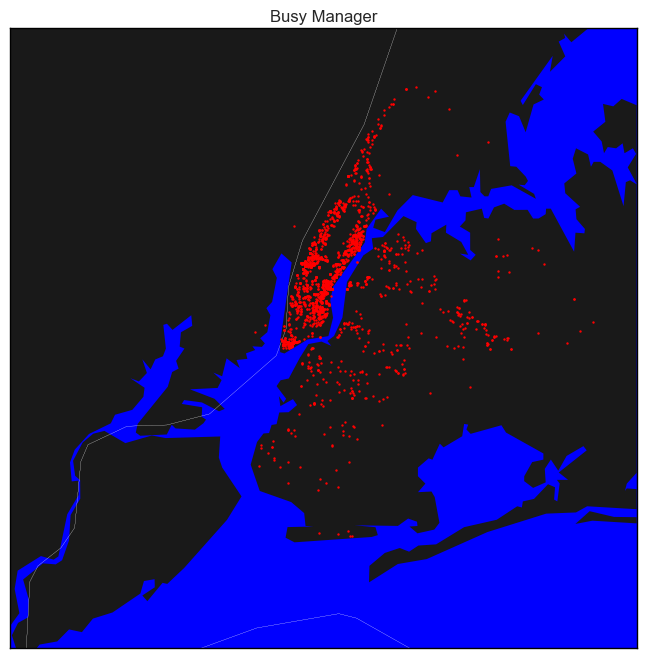

In [23]:
plt.figure(1, figsize=(12,6))

west, south, east, north = -74.26, 40.50, -73.70, 40.92

fig = plt.figure(figsize=(12,8))
m = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='h')

m.fillcontinents(color='#191919',lake_color='#0000ff') 
m.drawmapboundary(fill_color='#0000ff')
m.drawcountries(linewidth=0.3, color="w")             
m.drawstates(linewidth=0.1, color="w")
# Plot the data
# colors = {'high':'red', 'low':'blue', 'medium':'white'}
mxy = m(same_manager['longitude'].tolist(), same_manager['latitude'].tolist())
m.scatter(mxy[0], mxy[1], s=3, c='red', lw=0, alpha=1, zorder=5)
m.hexbin(mxy[0], mxy[1], gridsize=100)
plt.title("Busy Manager")
plt.show()

In [24]:
df_low = df[df['interest_level'] == 'low']
print len(df_low)
df_med = df[df['interest_level'] == 'medium']
print len(df_med)
df_high = df[df['interest_level'] == 'high']
print len(df_high)

34277
11221
3837


### longitude & latitude

Looking at the long & lat we can see some outliers.  it appears that there are many listings from Boston, a few from the midwest, one from so. cal and one in/near Africa.  

Reference for visualization <link>https://www.kaggle.com/beyondbeneath/talkingdata-mobile-user-demographics/geolocation-visualisations</link>

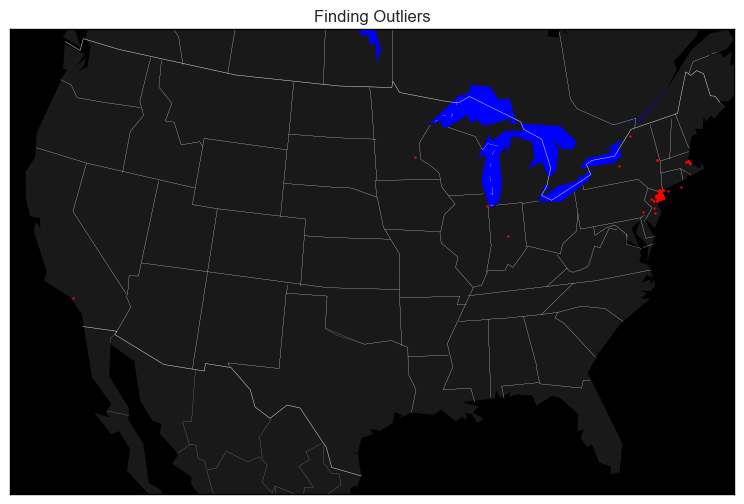

In [506]:
df_events = pd.read_csv('/Users/smoot/Desktop/kaggle/long_lat.csv')
plt.figure(1, figsize=(12,6))

m1 = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64,
  urcrnrlat=49, projection='lcc', lat_1=33, lat_2=45,
  lon_0=-95, resolution='c')


m1.fillcontinents(color='#191919',lake_co lor='#0000ff') 
m1.drawmapboundary(fill_color='#000000')
m1.drawcountries(linewidth=0.3, color="w")             
m1.drawstates(linewidth=0.1, color="w")
# Plot the data
mxy = m1(df_events['longitude'].tolist(), df_events['latitude'].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="#ff0000", lw=0, alpha=1, zorder=5)

plt.title("Finding Outliers")
plt.show()

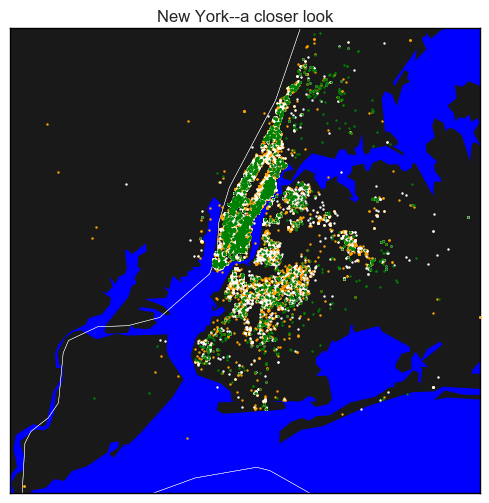

In [157]:
plt.figure(1, figsize=(12,6))

west, south, east, north = -74.26, 40.50, -73.70, 40.92

# fig = plt.figure(figsize=(12,8))
m2 = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='h')

m2.fillcontinents(color='#191919',lake_color='#0000ff') 
m2.drawmapboundary(fill_color='#0000ff')
m2.drawcountries(linewidth=0.3, color="w")             
m2.drawstates(linewidth=0.3, color="w")
# Plot the data
mxy_l = m2(df_low['longitude'].tolist(), df_low['latitude'].tolist())
mxy_m = m2(df_med['longitude'].tolist(), df_med['latitude'].tolist())
mxy_h = m2(df_high['longitude'].tolist(), df_high['latitude'].tolist())
m2.scatter(mxy_l[0], mxy_l[1], s=3, c='orange', lw=0, alpha=1, zorder=5)
m2.scatter(mxy_m[0], mxy_m[1], s=3, c='white', lw=0, alpha=1, zorder=5)
m2.scatter(mxy_h[0], mxy_h[1], s=3, c='green', lw=0, alpha=1, zorder=5)
m2.hexbin(mxy_l[0], mxy_l[1], gridsize=1000, bins='log')

plt.title("New York--a closer look")
plt.show()

In [53]:
loc_x = df[df['latitude'] == 0]
loc_x.index

Int64Index([106350,   2028,  37426,  39134,  46941,  49884,  63688,  66197,
             69423,  70841,  76934,  85521],
           dtype='int64')

In [5]:
# Price in the dataframe is $11111.  The price in the description is $1,025.  I'll fix that.
df.ix[4620]['description']
df.loc[4620, 'price'] = 1025

In [172]:
index_lookup(100710)

bathrooms                                                             1
bedrooms                                                              0
building_id                            5eddd80d0ce6b3b0eb59e501e1e9b1bf
created                                             2016-04-08 04:32:45
description           Available Now - Highly Unique, Downtown Manhat...
display_address                                        Lafayette Street
features                                   [Dogs Allowed, Cats Allowed]
interest_level                                                      low
latitude                                                        40.7198
listing_id                                                      6843855
longitude                                                      -73.9991
manager_id                             bc9a2ff7c931ce7de08f50d429134a16
photos                [https://photos.renthop.com/2/6843855_a1cd3e15...
price                                                           

In [128]:
h_lux = (df['price'] > 6000) & (df['interest_level'] == 'low')
# df[h_lux]

In [91]:
# There are a few outliers and several listings without coordinates.

print 'Latitude average:', df['latitude'].mean()
print 'Longitude average:', df['longitude'].mean()
print df['longitude'].sort_values()[:10]
print df['latitude'].sort_values(ascending=False)[:10]

Latitude average: 40.7415541218
Longitude average: -73.9557090929
39798    -118.2710
78568     -93.2705
72896     -87.6134
104822    -86.1527
18267     -76.6336
114028    -75.5214
16405     -75.1773
109507    -74.6637
108994    -74.6267
121891    -74.6248
Name: longitude, dtype: float64
78568    44.8835
16405    44.6038
18267    43.0346
81815    42.8725
4719     42.8724
80360    42.3459
85995    42.3459
24747    42.3459
872      42.3459
73065    42.3033
Name: latitude, dtype: float64


In [ ]:
# drop the prices that don't really make sense

bad_indexes = [53144, 87511, 117339, 32611, 113552, 85617, 113599, 102756, 22693, 109164, 51007, 115551, 83581, \
               95901, 88385, 55437, 57803]
for i in bad_indexes:
    df.drop(i, inplace=True)
df.shape

In [ ]:
df['description_len'] = [len(i) for i in df['description']]
df['num_photos'] = [len(i) for i in df['photos']]
df['num_features'] = [len(i) for i in df['features']]

df_t['num_photos'] = [len(i) for i in df_t['photos']]
df_t['description_len'] = [len(i) for i in df_t['description']]
df_t['num_features'] = [len(i) for i in df_t['features']]

categorical = ["display_address", "manager_id", "building_id"]
for f in categorical:
        if df[f].dtype=='object':
            #print(f)
            le = LabelEncoder()
            le.fit(list(df[f].values) + list(df_t[f].values))
            df[f] = le.transform(list(df[f].values))
            df_t[f] = le.transform(list(df_t[f].values))
            features_to_use.append(f)
            
df['features'] = df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
df_t['features'] = df_t["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
print df["features"].head()
tfidf = CountVectorizer(max_features=100)
tr_sparse = tfidf.fit_transform(df['features'])
te_sparse = tfidf.transform(df_t['features'])


df["created"] = pd.to_datetime(df["created"])
df["created_year"] = df["created"].dt.year
df["created_month"] = df["created"].dt.month
df["created_day"] = df["created"].dt.day
df["created_hour"] = df["created"].dt.hour

df_t["created"] = pd.to_datetime(df_t["created"])
df_t["created_hour"] = df_t["created"].dt.hour
df_t["created_year"] = df_t["created"].dt.year
df_t["created_month"] = df_t["created"].dt.month
df_t["created_day"] = df_t["created"].dt.day



# adding all these new features to use list #
features_to_use.extend(["created_year", "created_month", "created_day", "listing_id", "created_hour"])

In [ ]:
train_X = sparse.hstack([df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([df_t[features_to_use], te_sparse]).tocsr()
target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(df['interest_level'].apply(lambda x: target_num_map[x]))

In [787]:
r = pd.read_csv('/Users/smoot/Downloads/sample_submission.csv')

labels2idx = {label: i for i, label in enumerate(clf.classes_)}
labels2idx


submission = pd.DataFrame()
submission["listing_id"] = df["listing_id"]
for label in ["high", "medium", "low"]:
    submission[label] = y[:, labels2idx[label]]
submission.to_csv("submission_1.csv", index=False)

,listing_id,high,medium,low
0,7142618,0.077788,0.227529,0.694683
1,7210040,0.077788,0.227529,0.694683
2,7174566,0.077788,0.227529,0.694683
3,7191391,0.077788,0.227529,0.694683
4,7171695,0.077788,0.227529,0.694683
5,7225206,0.077788,0.227529,0.694683
6,7200075,0.077788,0.227529,0.694683
7,7145074,0.077788,0.227529,0.694683
8,7193645,0.077788,0.227529,0.694683
9,7147703,0.077788,0.227529,0.694683
